# Building a Data Pipeline with dlt

In this notebook, we will build a complete data pipeline from scratch using **dlt**.

Our goal is simple:

→ Fetch real data from an API  
→ Turn it into clean relational tables  
→ Load it into a database  
→ Explore and analyze it  

We will use the **Open Library API** as our data source and **DuckDB** as our database.

Along the way, you will learn:

- What a dlt source is  
- What a dlt pipeline does  
- How data moves through Extract → Normalize → Load  
- How to inspect and explore the final dataset  

By the end, you will understand not just how to run a pipeline, but what happens at each stage.


## 📦 Step 0: Install dependencies


In [1]:
# install dependencies first
!pip -q install dlt[duckdb]

<p>In this notebook we will use:</p>

<ul>
  <li><strong>dlt</strong> to extract, normalize, and load data</li>
  <li><strong>DuckDB</strong> as the destination database (runs locally inside Colab)</li>
</ul>

<p>
  DuckDB is great for beginners because it requires no setup and no credentials.
</p>

 ### 1️⃣  Step 1: Import libraries


<p>In this cell we import the libraries we will use throughout the notebook:</p>

<ul>
  <li><strong>dlt</strong> is the main library for building and running the pipeline</li>
  <li><strong>rest_api_source</strong> helps us define an API source using a simple configuration</li>
  <li><strong>islice</strong> (from <code>itertools</code>) is a small Python helper for previewing only a few records</li>
</ul>


In [2]:
import dlt
import dlt
from itertools import islice
from dlt.sources.rest_api import rest_api_source

### 2️⃣ Step 2: Define the API source (Open Library)




<p>
  In <strong>dlt</strong>, a <strong>source</strong> is the part of your pipeline that knows how to fetch data from somewhere.
  In this notebook, our source fetches data from the <strong>Open Library Search API</strong>.
</p>

<p>
  We define the source using <code>rest_api_source</code>, which lets us describe an API in a simple
  Python dictionary instead of writing lots of request code.
</p>

<p>
  📖 <strong>Open Library Search API docs:</strong><br>
  <a href="https://openlibrary.org/dev/docs/api/search" target="_blank">
    https://openlibrary.org/dev/docs/api/search
  </a>
</p>

In [3]:
def openlibrary_source(query: str = "harry potter"):

    return rest_api_source({
        "client": {
            "base_url": "https://openlibrary.org",
        },
        "resource_defaults": {
            "primary_key": "key",
            "write_disposition": "replace",
        },
        "resources": [
            {
                "name": "books",
                "endpoint": {
                    "path": "search.json",
                    "params": {
                        "q": query,
                        "limit": 100,
                    },
                    "data_selector": "docs",
                    "paginator": {
                        "type": "offset",
                        "limit": 100,
                        "offset_param": "offset",
                        "limit_param": "limit",
                        "total_path": "numFound",
                    },
                },
            },
        ],
    })


### 3️⃣ Step 3: Create the dlt pipeline

In [4]:
pipeline = dlt.pipeline(
    pipeline_name="ol_demo",
    destination="duckdb",
    dataset_name="ol_data",
)

## 3️⃣ Step 3: Pipeline Breakdown

At this point we have defined two key building blocks:

- **The source** describes where the data comes from and how to fetch it from the API.  
- **The pipeline** describes where the data should go (DuckDB) and keeps track of tables, schemas, and run history.  

---

Instead of running everything at once, we will now run the pipeline in three separate phases so you can clearly see what happens at each stage:

1. **Extract**: download raw data from the API  
2. **Normalize**: turn nested JSON into relational tables  
3. **Load**: write those tables into DuckDB  




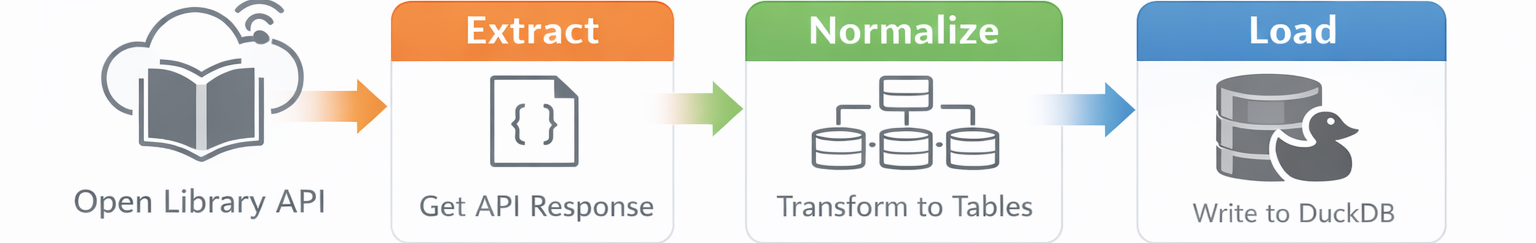

Once these steps make sense, we will run the full workflow again using one command:

```python
pipeline.run()


## 4️⃣ Step 4: Extract data from the API

Now we run the first stage of the pipeline: **Extract**.

Extract means:

- dlt sends requests to the Open Library API
- the raw JSON responses are downloaded
- the results are stored in dlt’s local working folder

At this stage, the data is **not** in DuckDB yet. We are just confirming that we successfully pulled data from the API.

In [5]:
extract_info = pipeline.extract(openlibrary_source())

---

### What we will print

After extraction, we will print a small summary showing:

- which **resources** were extracted
- which **tables** will be created later
- how many rows were extracted per resource

This helps confirm that the pipeline is working before we move on to normalization.

In [7]:

load_id = extract_info.loads_ids[-1]
m = extract_info.metrics[load_id][0]

print("Resources:", list(m["resource_metrics"].keys()))
print("Tables:", list(m["table_metrics"].keys()))
extract_info = pipeline.extract(openlibrary_source())
print("Load ID:", load_id)
print()

for resource, rm in m["resource_metrics"].items():
    print(f"Resource: {resource}")
    print(f"rows extracted: {rm.items_count}")
    print()

Resources: ['books']
Tables: ['books']
Load ID: 1770819724.7555451

Resource: books
  rows extracted: 3756



### What you should see after Extract

In our case, Extract shows only **one resource and one table**:

- **Resources:** `['books']`  
- **Tables:** `['books']`

That is expected.

The `search` endpoint returns a list of book results, so dlt stores those rows in a single table called `search`. The interesting part comes next, because many fields inside each row are lists or nested objects. Those will turn into additional tables during **Normalize**.

Example output:

- **25 rows extracted** means we pulled 25 search results (books)  

---

## 5️⃣ Step 5: Normalize

Now we run **Normalize**.

APIs often return nested JSON. For example, a book can have:

- multiple authors (a list)
- multiple editions (a nested object with its own list)
- multiple identifiers (another list)

Normalize converts that nested structure into separate tables so the data becomes easier to query.

You will usually see new child tables appear with names like:

- `books__author_name`
- `books__editions__docs`
- `books__editions__docs__language`

These tables are linked back to the main `books` table using internal dlt ID columns.

In the next cell, we will print a short summary showing which tables were created and how many rows were written to each table.


In [8]:
normalize_info = pipeline.normalize()

In [9]:
load_id = normalize_info.loads_ids[-1]
m = normalize_info.metrics[load_id][0]

print("Load ID:", load_id)
print()

print("Tables created/updated:")
for table_name, tm in m["table_metrics"].items():
    # skip dlt internal tables to keep it beginner-friendly
    if table_name.startswith("_dlt"):
        continue
    print(f"  - {table_name}: {tm.items_count} rows")


Load ID: 1770819807.3935525

Tables created/updated:
  - books: 3756 rows
  - books__author_key: 4600 rows
  - books__author_name: 4600 rows
  - books__ia: 3422 rows
  - books__ia_collection: 2724 rows
  - books__language: 3748 rows
  - books__id_standard_ebooks: 12 rows
  - books__id_librivox: 60 rows
  - books__id_project_gutenberg: 54 rows


### What happened during Normalize?

After running `pipeline.normalize()`, we now see multiple tables instead of just one.

Tables created/updated:

- `books`: 25 rows  
- `books__author_key`: 29 rows  
- `books__author_name`: 29 rows  
- `books__editions__docs`: 25 rows  
- `books__editions__docs__language`: 24 rows  
- `books__ia`: 82 rows  

---

### What does this mean?

We started with **25 book search results** in the `search` table.

During normalization:

- Each book may have **multiple authors**, so those were split into:
  - `books__author_name`
  - `books__author_key`

- Each book may contain **edition information**, which became:
  - `books__editions__docs`

- Some editions contain **language information**, which became:
  - `books__editions__docs__language`

- The `ia` field (Internet Archive IDs) is a list, so it became:
  - `books__ia`

This is the key moment in the pipeline.

The data has been transformed from nested JSON into a **relational structure** with multiple linked tables. This makes it much easier to query and analyze.


## 6️⃣ Step 6: Load

Now we run the final stage of the pipeline: **Load**.

Load means:

- dlt creates tables in DuckDB (if they do not already exist)
- the normalized rows are inserted into those tables
- the pipeline records the load in its internal tracking tables



In [10]:
load_info = pipeline.load()


After this step, the data is fully stored in the database and ready to query.

At this point:

- The `books` table contains our books
- The related tables (such as `books__author_name` and `books__editions__docs`) contain the exploded nested data
- Everything is now queryable using `pipeline.dataset()` or SQL

This is the moment where the data officially moves from “pipeline processing” into a database you can explore.

## 7️⃣ Run the entire pipeline in one command

Now that we have walked through each step individually, we can run the entire workflow using a single command:



In [11]:
load_info = pipeline.run(openlibrary_source())

<h3>What does <code>pipeline.run()</code> do?</h3>

<p>
  <code>pipeline.run()</code> simply combines the three steps we already executed manually:
</p>

<ol>
  <li><strong>Extract</strong> – fetch data from the Open Library API</li>
  <li><strong>Normalize</strong> – convert nested JSON into relational tables</li>
  <li><strong>Load</strong> – write those tables into DuckDB</li>
</ol>

<p>In other words, this:</p>

<pre><code>pipeline.run(source)</code></pre>

<p>is equivalent to:</p>

<pre><code>pipeline.extract(source)
pipeline.normalize()
pipeline.load()</code></pre>

<p>
  There is no hidden magic. It just runs the full ELT process in order.
</p>


## 8️⃣ Inspect the loaded data (the fun part)

Now that the data is loaded into DuckDB, we can inspect it using `pipeline.dataset()`.

This gives us a convenient Python interface for exploring the tables that dlt created, without writing SQL.

---

### List available tables

First, let’s see what tables exist in the dataset:

In [12]:
ds = pipeline.dataset()

In [13]:
ds.tables

['books',
 'books__author_key',
 'books__author_name',
 'books__ia',
 'books__ia_collection',
 'books__language',
 'books__id_standard_ebooks',
 'books__id_librivox',
 'books__id_project_gutenberg',
 '_dlt_version',
 '_dlt_loads',
 '_dlt_pipeline_state']

In [17]:
df = ds.books.df()      # main table
df.head(3)

,cover_edition_key,cover_i,ebook_access,edition_count,first_publish_year,has_fulltext,key,lending_edition_s,lending_identifier_s,public_scan_b,title,_dlt_load_id,_dlt_id,subtitle
0,OL61027601M,15155833,borrowable,396,1997,True,/works/OL82563W,OL38565767M,harrypotterylapi0000rowl_q5r6,False,Harry Potter and the Philosopher's Stone,1770819876.9353185,lGJrV2BS8Z9qJQ,None
1,OL26378158M,15158660,printdisabled,144,2007,True,/works/OL82586W,None,None,False,Harry Potter and the Deathly Hallows,1770819876.9353185,F9W0WQlLwgvsFw,None
2,OL26234270M,10580435,borrowable,278,1999,True,/works/OL82536W,OL48101764M,bdrc-W8LS66814,False,Harry Potter and the Prisoner of Azkaban,1770819876.9353185,kSdfO1XbBVAjmQ,None


## 9️⃣ dlt makes this easier… but not effortless

What dlt already handled for us:

✔ API requests  
✔ JSON normalization  
✔ Table creation  
✔ Database loading  
✔ Simple dataset inspection  

---

But there are still friction points:

• Getting the REST API config exactly right  
• Remembering paginator syntax  
• Remembering how to inspect tables  
• Writing Python or SQL to get insights  
• Debugging schema or pagination issues  

It works… but it still takes effort.

---

## 🚀 The next step: LLM-powered workflows

dlt now integrates LLMs directly into the workflow to make:

• Pipeline runs easier  
• Debugging faster  
• Schema inspection simpler  
• Data analysis more natural  

Instead of writing glue code, you can use natural language.

In the next demo, we will see what that looks like.
